In [1]:
# set up matplotlib
%matplotlib widget
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams.update({"font.size": 14})

In [2]:
import numpy as np
import xarray as xr
from scipy.special import j0
from scipy.interpolate import RectBivariateSpline
from xbout import open_boutdataset

In [3]:
case = "3" # Case 1 is for anomalous density diffusion only.
filepath = "mms" + str(case) + "_n/BOUT.dmp.*.nc"
#filepath = "test" + str(case) + "/BOUT.dmp.0.nc"

ds = open_boutdataset(datapath=filepath, chunks={"t": 4})
dsn = xr.open_dataset("circle_midres.fci.nc")

# Use squeeze() to get rid of the y-dimension, which has length 1 usually unless turbulent.
ds = ds.squeeze(drop=True)
dsn = dsn.squeeze(drop=True)

for key,val in ds.items():
    print(key)

Read in:
<xbout.BoutDataset>
Contains:
<xarray.Dataset> Size: 666MB
Dimensions:             (x: 260, y: 1, z: 260, t: 201)
Coordinates:
    dx                  (x, y, z) float64 541kB dask.array<chunksize=(260, 1, 260), meta=np.ndarray>
    dy                  (x, y, z) float64 541kB dask.array<chunksize=(260, 1, 260), meta=np.ndarray>
    dz                  (x, y, z) float64 541kB dask.array<chunksize=(260, 1, 260), meta=np.ndarray>
  * t                   (t) float64 2kB 0.0 5e+05 1e+06 ... 9.95e+07 1e+08
  * x                   (x) int64 2kB 0 1 2 3 4 5 6 ... 254 255 256 257 258 259
  * y                   (y) float64 8B 0.1963
  * z                   (z) float64 2kB 0.001923 0.005769 ... 0.9942 0.9981
Data variables: (12/52)
    Bxy                 (x, y, z) float64 541kB dask.array<chunksize=(260, 1, 260), meta=np.ndarray>
    G1                  (x, y, z) float64 541kB dask.array<chunksize=(260, 1, 260), meta=np.ndarray>
    G2                  (x, y, z) float64 541kB dask.array

/home/tirkas1/miniconda3/lib/python3.13/site-packages/xbout/load.py:341: UserWarning: No geometry type found, no physical coordinates will be added
  warn("No geometry type found, no physical coordinates will be added")


In [4]:
dx = ds["dx"].isel(z=0).values

# Get rid of existing "x" coordinate, which is just the index values.
#ds = ds.drop("x")

# Create a new coordinate, which is length in units of rho_s
ds = ds.assign_coords(x=np.arange(ds.sizes["x"])*dx)

#Store just initial values as well.
ds_initial = ds.isel(t=0)

In [5]:
dens = ds["Nh+"][:,2:-2,:]
dens_true = dens.copy()

mask = dsn["in_mask"][2:-2,:]
ghost_id = dsn["ghost_id"].values
gst_pts = dsn["ghost_pts"].values
bdy_pts = dsn["bndry_pts"].values
img_pts = dsn["image_pts"].values
normals = dsn["normals"].values
is_plasma = dsn["is_plasma"].values
Rarr = dsn["R"].values[2:-2,:]
Zarr = dsn["Z"].values

timestep_for_errs_early = 10
timestep_for_errs_late = 100
spl_e = RectBivariateSpline(Rarr[:,0], Zarr[0,:], dens.values[timestep_for_errs_early,:,:], kx=1, ky=1)
spl_l = RectBivariateSpline(Rarr[:,0], Zarr[0,:], dens.values[timestep_for_errs_late,:,:], kx=1, ky=1)

In [6]:
beta0 = 3.8317059702075125
xc, zc = 1.5, 0.0

x_unit = 0.00022846974366979959 #rho_s0
w_unit = 95788333.030660808    #Omega_ci
t_unit = 1/w_unit

nx = 64*4 #int(case)
nz = nx + 4
dx = np.float64(1.0) / np.float64(nx)
dz = np.float64(1.0) / np.float64(nz)

# Centers in x; faces/nodes in z if that's your convention
x = (np.arange(nx, dtype=np.float64) + 0.5) * dx # centered x
z = (np.arange(nz, dtype=np.float64)) * dz       # unshifted z

xhalf  = np.float64(x[len(x)//2])
zhalf  = np.float64(z[len(z)//2])

xx, zz = np.meshgrid(x,z,indexing='ij',copy=False)
a      = np.float64(0.333333333333333)
D      = np.float64(0.2)#/(x_unit*x_unit*w_unit)
t64 = np.asarray(ds["t_array"].values, dtype=np.float64) # 1D time
t_norm = t64*t_unit
#spatial = ((xx - xhalf)**2 + (zz-zhalf)**2)
spatial = j0(beta0*np.hypot(xx - xhalf, zz - zhalf)/a)
#temp = 4.0*D*t_norm #t64/t64[-1]
a_norm = a/x_unit
temp = np.exp(-D * (beta0 / a)**2 * (t_norm))

#dens_true[:,:,:] = np.asarray(spatial)[np.newaxis,:,:] + np.asarray(temp)[:,np.newaxis,np.newaxis]
dens_true[:,:,:] = np.asarray(spatial)[np.newaxis,:,:]*np.asarray(temp)[:,np.newaxis,np.newaxis]

bdy_pts_xz_e = spl_e.ev(bdy_pts[:,0], bdy_pts[:,1])
bdy_pts_xz_l = spl_l.ev(bdy_pts[:,0], bdy_pts[:,1])
print("Linf bdy err if dirichlet: " + str(np.max(np.abs(bdy_pts_xz_e))))
print("L2 bdy err (early) if dirichlet?: "  + str(np.mean(np.abs(bdy_pts_xz_e))))
print("L2 bdy err (late) if dirichlet?: "  + str(np.mean(np.abs(bdy_pts_xz_l))))

#dndR = spl.ev(bdy_pts[:,0], bdy_pts[:,1], dx=1, dy=0) # ∂n/∂R at boundary points
#dndZ = spl.ev(bdy_pts[:,0], bdy_pts[:,1], dx=0, dy=1) # ∂n/∂Z at boundary points
#dn_dn = dndR * normals[:,0] + dndZ * normals[:,1]     # normal derivative
dP = np.einsum('ij,ij->i', (bdy_pts - img_pts), -normals)
dG = np.einsum('ij,ij->i', (gst_pts - bdy_pts), -normals)
dn_dn_e = (spl_e.ev(img_pts[:,0], img_pts[:,1]) - spl_e.ev(gst_pts[:,0], gst_pts[:,1])) / (dP + dG)
dn_dn_l = (spl_l.ev(img_pts[:,0], img_pts[:,1]) - spl_l.ev(gst_pts[:,0], gst_pts[:,1])) / (dP + dG)

Linf = np.max(np.abs(dn_dn_e))
L2   = np.sqrt(np.mean(dn_dn_e**2))
L2   = np.sqrt(np.mean(dn_dn_l**2))
print("Linf bdy err if neumann: " + str(np.max(np.abs(dn_dn_e))))
print("L2 bdy err (early) if neumann: " + str(np.sqrt(np.mean(dn_dn_e**2))))
print("L2 bdy err (late) if neumann: " + str(np.sqrt(np.mean(dn_dn_l**2))))

Linf bdy err if dirichlet: 0.09945922240625414
L2 bdy err (early) if dirichlet?: 0.0992216423138613
L2 bdy err (late) if dirichlet?: 0.0015982344084960022
Linf bdy err if neumann: 0.0010151854471531592
L2 bdy err (early) if neumann: 0.00011673685804320517
L2 bdy err (late) if neumann: 4.420296859878754e-10


In [ ]:
img_pts_xz = spl_e.ev(img_pts[:,0], img_pts[:,1])

i = 0
for idx in range(nx+4):
    for idz in range(nz):
        gid = int(ghost_id[idx,idz])
        if gid >= 0:
            print(gid)
            if (not (is_plasma[gid,0] and is_plasma[gid,1] and is_plasma[gid,2] and is_plasma[gid,3])):
               print("Contains multiple ghost cell corners.")
            print(img_pts[gid])
            print(img_pts_xz[gid])

In [ ]:

dens0 = dens.where(mask) - np.nanmean(dens.where(mask), axis=(1,2), keepdims=True)
true0 = dens_true.where(mask) - np.nanmean(dens_true.where(mask), axis=(1,2), keepdims=True)
#dens0 = dens.where(mask) - np.nanmean(dens.where(mask), axis=(1,2), keepdims=True)
#true0 = dens_true.where(mask) - np.nanmean(dens_true.where(mask), axis=(1,2), keepdims=True)

int_ind = 80
#dens0 = dens.values[:,int_ind:-int_ind,int_ind:-int_ind] - np.nanmean(dens.values[:,int_ind:-int_ind,int_ind:-int_ind], axis=(1,2), keepdims=True)
#true0 = dens_true.values[:,int_ind:-int_ind,int_ind:-int_ind] - np.nanmean(dens_true.values[:,int_ind:-int_ind,int_ind:-int_ind], axis=(1,2), keepdims=True)
dens_diff0 = np.abs(dens0 - true0)

dens_diff = np.abs(dens.where(mask) - dens_true.where(mask))
l2_err_t = np.sqrt(np.nanmean(dens_diff**2, axis=(1, 2)))
l2_err_n_t = np.sqrt(np.nanmean(dens_diff0**2, axis=(1, 2)))
l2_relerr_t = l2_err_t/np.sqrt(np.nanmean(dens_true**2, axis=(1,2)))
l2_relerr_n_t = l2_err_n_t/np.sqrt(np.nanmean(true0**2, axis=(1,2)))

print("Dirichlet Linf int err: " + str(np.max(l2_err_t)))
print("Dirichlet L2 int err (early): "   + str(l2_err_t[timestep_for_errs_early]))
print("Dirichlet L2 int err (late): "   + str(l2_err_t[timestep_for_errs_late]))

print("Neumann Linf int err: " + str(np.max(l2_err_n_t)))
print("Neumann L2 int err (early): "   + str(l2_err_n_t[timestep_for_errs_early]))
print("Neumann L2 int err (late): "   + str(l2_err_n_t[timestep_for_errs_late]))

#l2_err = np.sqrt(np.nanmean(dens_diff[100,:,:]**2))
#l2_unnorm = np.sqrt(np.nansum(dens_diff[100,:,:]**2)*dx*dz)
#l2_rel = np.sqrt(np.nansum(dens_diff[100,:,:]**2)*dx*dz) / np.sqrt(np.nansum(dens_true[100,:,:]**2)*dx*dz)
#print("L2 (RMS): "    + str(l2_err))
#print("L2 (unnorm): " + str(l2_unnorm))
#print("L2 (rel): "    + str(l2_rel))
#
true = dens_true.values[1:10, len(x)//2, len(z)//2] - dens_true.values[0, len(x)//2, len(z)//2]
sim = dens.values[1:10, len(x)//2, len(z)//2] - dens.values[0, len(x)//2, len(z)//2]
#print(*np.abs(sim-true), sep="\n")

init_dens_diff = dens_diff[0,:,:]
mask2 = init_dens_diff.notnull() & (init_dens_diff >= 1e-10)
nerrs = int(mask2.sum().compute())

ii, jj = np.where(mask2)

if nerrs > 0:
    print(init_dens_diff.values[ii[0],jj[0]])
    print(dens.values[0,ii[0],jj[0]])
    print(dens_true.values[0,ii[0],jj[0]])

print(nerrs)

plt.close('all')      # optional, but guarantees a clean slate for the whole kernel
fig, ax = plt.subplots()  # new figure/axes each run
print(l2_err_n_t[-1])
ax.plot(t_norm, l2_err_n_t)
ax.set_xlabel("Time [s]")
ax.set_ylabel("L2 error (RMS)")
ax.set_title("Time evolution of L2 error")
plt.show()


Observed orders (p) between refinements:
  Boundary L2 (early) : p12=1.782, p23=0.923, avg=1.353
  Boundary L2 (half)  : p12=4.364, p23=1.225, avg=2.794
  Interior L2 (early) : p12=0.932, p23=1.054, avg=0.993
  Interior L2 (half)  : p12=1.791, p23=2.581, avg=2.186
  Boundary L∞         : p12=1.672, p23=0.328, avg=1.000
  Interior L∞         : p12=0.919, p23=1.058, avg=0.989


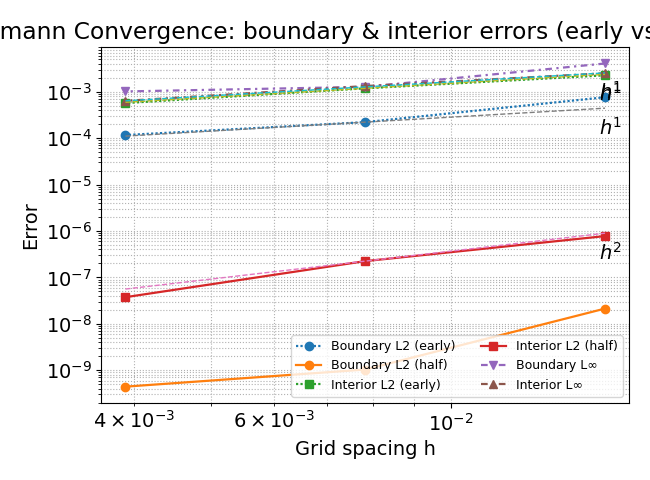

In [7]:
# convegence_plot.py
# Usage: fill in the error arrays below and run:  python convergence_plot.py

import numpy as np
import matplotlib.pyplot as plt

# --- Grid spacings (you can scale by your base h0 if you want) ---
h0 = 1/64               # set to your base h if you care about absolute values
h = np.array([h0, h0/2, h0/4], dtype=float)

# ========================= FILL THESE IN =========================
# L2 @ EARLY time (transients present)
# t=10 fairly transient-y
E_b_L2_early = np.array([0.0007614422345883843, 0.00022134669390331673, 0.00011673685804320517])
E_i_L2_early = np.array([0.0022584847974055897, 0.0011840284647518565, 0.000570079252783183])

# L2 @ HALF simulation time (transients gone, your current metric)
E_b_L2_half  = np.array([2.1276209274483993e-08, 1.0335643175246501e-09, 4.420296859878754e-10])
E_i_L2_half  = np.array([7.759372602920076e-07, 2.2416682640288222e-07, 3.7451474635968326e-08])

# L∞ (single time of your choice—keep as what you were using before)
E_b_Linf     = np.array([0.004061576219400536,  0.00127447165992785, 0.0010151854471531592])
E_i_Linf     = np.array([0.0025049424051301356, 0.001324529002164696, 0.0006359620760523504])
# =================================================================

series = {
    # L2 (two times)
    "Boundary L2 (early)" : E_b_L2_early,
    "Boundary L2 (half)"  : E_b_L2_half,
    "Interior L2 (early)" : E_i_L2_early,
    "Interior L2 (half)"  : E_i_L2_half,
    # L∞
    "Boundary L∞"         : E_b_Linf,
    "Interior L∞"         : E_i_Linf,
}

def observed_order(h, e):
    return np.log(e[:-1]/e[1:]) / np.log(h[:-1]/h[1:])  # p between levels


def add_ref_slope(ax, x_anchor, y_anchor, p, xspan, where="right", offset=(-4, -6)):
    """
    Draw a dashed reference line of slope p through (x_anchor, y_anchor)
    over xspan=(xmin, xmax) on log-log axes, and label it near one end.

    where: "left", "right", or "center"
    offset: (dx, dy) text offset in screen points from the chosen anchor
    """
    x_ref = np.array(xspan, dtype=float)
    y_ref = y_anchor * (x_ref / x_anchor)**p
    ax.loglog(x_ref, y_ref, linestyle='--', linewidth=1.0)

    if where == "left":
        xlab = min(xspan)
    elif where == "right":
        xlab = max(xspan)
    else:  # center (geometric)
        xlab = np.sqrt(xspan[0] * xspan[1])

    ylab = y_anchor * (xlab / x_anchor)**p

    # Nice MathText label; change to f"h^{p:g}" if you prefer plain text
    label = rf"$h^{{{p:g}}}$"

    ax.annotate(
        label,
        xy=(xlab, ylab),
        xytext=offset, textcoords="offset points",
        ha="right" if where == "left" else ("left" if where == "right" else "center"),
        va="top"
    )

# --- Print observed orders ---
print("Observed orders (p) between refinements:")
for name, e in series.items():
    p = observed_order(h, e)
    print(f"  {name:20s}: p12={p[0]:.3f}, p23={p[1]:.3f}, avg={p.mean():.3f}")

# --- Plot ---
fig, ax = plt.subplots(figsize=(6.5, 4.8))

# Use distinct linestyles for time separation on L2 series
linestyles = {
    "Boundary L2 (early)": (0, (1, 1)),
    "Boundary L2 (half)" : "-",
    "Interior L2 (early)": (0, (1, 1)),
    "Interior L2 (half)" : "-",
    "Boundary L∞"        : (0, (3, 2, 1, 2)),
    "Interior L∞"        : (0, (3, 2, 1, 2)),
}

markers = {
    "Boundary L2 (early)": "o",
    "Boundary L2 (half)" : "o",
    "Interior L2 (early)": "s",
    "Interior L2 (half)" : "s",
    "Boundary L∞"        : "v",
    "Interior L∞"        : "^",
}

for name, e in series.items():
    ax.loglog(h, e, marker=markers[name], linewidth=1.6,
              linestyle=linestyles[name], label=name)

ax.set_xlabel("Grid spacing h")
ax.set_ylabel("Error")
ax.set_title("Neumann Convergence: boundary & interior errors (early vs half-time)")
ax.grid(True, which='both', ls=':')

# Optional: reference slopes (set to your expected rates)
# Example shows p=2 as a general reference drawn near midpoints of the L2(half) curves
ref_p = 2.0
x_anchor = h[1]
y_anchor = E_i_L2_half[1]
add_ref_slope(ax, x_anchor, y_anchor, ref_p, (h[-1], h[0]))

ref_p = 1.0
x_anchor = h[1]
y_anchor = E_b_L2_early[1]
add_ref_slope(ax, x_anchor, y_anchor, ref_p, (h[-1], h[0]))

ref_p = 1.0
x_anchor = h[1]
y_anchor = E_i_L2_early[1]
add_ref_slope(ax, x_anchor, y_anchor, ref_p, (h[-1], h[0]))

ref_p = 1.0
x_anchor = h[1]
y_anchor = E_b_Linf[1]
add_ref_slope(ax, x_anchor, y_anchor, ref_p, (h[-1], h[0]))

ax.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

In [ ]:
dens_diff0.bout.animate2D(aspect='equal')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# dens: shape (nt, nx, nz)
# time: shape (nt,)
# dx, dz: scalar cell sizes (uniform grid)
# If nonuniform, use cell area weights instead of dx*dz.

area = dx * dz
# Compute L2 amplitude (norm of mean-free component)
amp = np.sqrt(np.nansum(dens0.where(mask)**2, axis=(1, 2)) * area)

# Take the natural log of amplitude
logA = np.log(amp)

# Choose a time window where the decay is clean (exclude t=0 if noisy)
t_fit = t_norm[5:]       # skip a few early points if needed
logA_fit = logA[5:]

# Linear fit: log(A) = a + b * t
coeffs = np.polyfit(t_fit, logA_fit, 1)
slope, intercept = coeffs[0], coeffs[1]

print(f"Measured slope = {slope:.6e}  (expected -D*alpha1^2)")

# Example for first root of J1
from scipy.special import jn_zeros
alpha1 = jn_zeros(1, 1)[0]  # ~3.8317 for J1's first root

expected_slope = -D * alpha1**2/a**2
print(f"Expected slope = {expected_slope:.6e}")
print(f"Ratio (measured/expected) = {slope / expected_slope:.3f}")

plt.figure(figsize=(6,4))
plt.plot(t_fit, logA_fit, 'o-', label='log(L2 amplitude)')
plt.plot(t_fit, intercept + slope*t_fit, 'r--', label=f'Fit slope = {slope:.3e}')
plt.plot(t_fit, np.log(amp[0]) + expected_slope*t_fit, 'k:', 
         label=f'Expected slope = {expected_slope:.3e}')
plt.xlabel('Time')
plt.ylabel('log(L2 amplitude)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
res_true = (D/(x_unit*x_unit*w_unit))*(beta0**2/(a/x_unit)**2)*dens_true.where(mask)[0,:,:]
res_sim = ds["SNh+"][0,2:-2,:].where(mask)

res = res_sim - res_true

print(np.shape(res))

res_L2 = np.sqrt(np.nansum((res**2)) * dx*dz)
print("||res||_L2 =", float(res_L2)) #, "   relative =", float(rel_res))

In [ ]:
# dens, dens_mms: arrays shaped (nt, ny, nx)  [cell-centered]
# w: weights shaped (ny, nx); e.g. fractional fluid area in each cell ∈ [0,1]
#    - outside fluid or ghost cells: w = 0
#    - full fluid cell: w = 1
#    - cut cell: w = fluid area fraction in (0,1)

def fit_constant_per_time(u, v, w):
    # returns C*(t) that minimizes || (u - v - C) ||_L2 over weighted fluid region
    num = np.sum(w[None, ...] * (u - v), axis=(1,2))
    den = np.sum(w, axis=(0,1))
    return num / den  # shape (nt,)

def gauge_fixed_error(u, v, w):
    C = fit_constant_per_time(u, v, w)                # (nt,)
    return (u - v) - C[:, None, None]                 # broadcast to (nt, ny, nx)

# Example usage:
# If you only have a boolean mask, make weights = mask.astype(float)
# and set w=0 in any ghost/solid/IB-internal cells.
w = mask.values.astype(float)    # preferred (cut-cell fractions)
# w = mask.astype(float)  # fallback (binary)
err = gauge_fixed_error(dens.values, dens_true.values, w)

# Final-time error field and norms over fluid region:
ef = err[10]
w_sum = np.sum(w)
L2_final = np.sqrt(np.sum(w * ef**2) / w_sum)
Linf_final = np.max(np.abs(ef[w > 0]))

print(L2_final)


In [ ]:
print(dens.values[0,len(x)//2, len(z)//2])
print(dens_true.values[0,len(x)//2, len(z)//2])
print(dens.values[1,len(x)//2, len(z)//2])
print(dens_true.values[1,len(x)//2, len(z)//2])
print((dens - dens_true).values[1,len(x)//2,len(z)//2])

In [ ]:
print(dens0.values[0,len(x)//2, len(z)//2])
print(true0.values[0,len(x)//2, len(z)//2])
print(dens0.values[1,len(x)//2, len(z)//2])
print(true0.values[1,len(x)//2, len(z)//2])
print((dens0 - true0).values[1,len(x)//2,len(z)//2])

In [ ]:
import numpy as np

def build_core_mask(fluid_mask, radius=1):
    """
    fluid_mask: (ny, nx) bool or 0/1 — True where fluid (not solid/ghost)
    radius: how many rings to erode (radius=1 for 2nd-order central stencil)
    """
    fluid = fluid_mask.astype(bool).copy()
    core = fluid.copy()
    for _ in range(radius):
        # all 4 neighbors present
        core[:-1,:]  &= fluid[1:,:]
        core[1:,:]   &= fluid[:-1,:]
        core[:,:-1]  &= fluid[:,1:]
        core[:,1:]   &= fluid[:,:-1]
        # also drop the border where centered diffs don't fit
        core[[0,-1],:] = False
        core[:,[0,-1]] = False
        fluid = core  # iterate the erosion
    return core

def h1_seminorm_time(u, v, fluid_mask, dx, dy, radius=1, w_frac=None):
    """
    u, v: (nt, ny, nx) numerical and MMS fields at same times
    fluid_mask: (ny, nx) True on fluid cells (False on solid/ghost)
    dx, dy: spacings (scalars) for uniform grid
    radius: erosion in cells for the interior core (default 1)
    w_frac: optional (ny, nx) fractional fluid areas in [0,1]; if None, uses 1.0 on core
    Returns: (nt,) array of H1 seminorms over the interior core
    """
    nt, ny, nx = u.shape
    core = build_core_mask(fluid_mask, radius=radius)

    # centered differences on interior strip; time is broadcast
    ux_u   = (u[:, :, 2:] - u[:, :, :-2]) / (2.0*dx)
    uy_u   = (u[:, 2:, :] - u[:, :-2, :]) / (2.0*dy)
    ux_v   = (v[:, :, 2:] - v[:, :, :-2]) / (2.0*dx)
    uy_v   = (v[:, 2:, :] - v[:, :-2, :]) / (2.0*dy)

    # core aligned to the interior stencil (strip 1 cell from each side)
    core_int = core[1:-1, 1:-1]  # (ny-2, nx-2)
    if w_frac is None:
        w_int = core_int.astype(float)
    else:
        # restrict weights to core and zero out non-core
        w_int = (w_frac[1:-1, 1:-1] * core_int.astype(float))

    # gradient error on the aligned interior
    ex = ux_u - ux_v  # (nt, ny, nx-2) -> aligns with [:, :, 1:-1] in x
    ey = uy_u - uy_v  # (nt, ny-2, nx) -> aligns with [:, 1:-1, :] in y
    # we need the overlap region (ny-2, nx-2)
    ex_c = ex[:, 1:-1, :]           # drop first/last y to get (nt, ny-2, nx-2)
    ey_c = ey[:, :, 1:-1]           # drop first/last x to get (nt, ny-2, nx-2)

    grad_err_sq = ex_c**2 + ey_c**2  # (nt, ny-2, nx-2)

    # apply weights and integrate
    w2d = w_int[None, :, :]                # (1, ny-2, nx-2) for broadcast
    num = np.sum(w2d * grad_err_sq, axis=(1,2)) * dx * dy  # (nt,)
    den = np.sum(w_int) * dx * dy + 0.0                    # scalar area of core

    # If the core is empty, avoid divide-by-zero
    den = max(den, 1e-300)
    return np.sqrt(num / den)             # (nt,)

# --- Optional: interior L2 with gauge removed on the same core ---
def l2_interior_gaugefree_time(u, v, fluid_mask, dx, dy, radius=1, w_frac=None):
    """
    Returns (nt,) of interior L2 errors after subtracting, per time, the best-fit constant
    computed over the same interior core and weights.
    """
    core = build_core_mask(fluid_mask, radius=radius)
    core2 = core.astype(float)
    if w_frac is None:
        w_full = core2
    else:
        w_full = core2 * w_frac  # (ny, nx)

    # mask arrays
    uI = u * w_full[None, ...]
    vI = v * w_full[None, ...]
    w_sum = np.sum(w_full) * dx * dy + 0.0

    # best-fit constant C*(t) over the interior core
    C_t = np.sum(uI - vI, axis=(1,2)) / (np.sum(w_full) + 1e-300)  # (nt,)
    eI = (u - v) - C_t[:, None, None]

    num = np.sum((eI**2) * w_full[None, ...], axis=(1,2)) * dx * dy
    return np.sqrt(num / w_sum)


In [ ]:
import numpy as np

def build_core_mask(fluid_mask):
    """
    Erode by 1 cell so a 2nd-order centered stencil fits entirely in the fluid.
    fluid_mask: (ny, nx) bool (True = fluid)
    returns    : (ny, nx) bool 'core' mask
    """
    f = np.asarray(fluid_mask, dtype=bool)
    core = f.copy()
    # require 4-neighbors to be fluid
    core[:-1,:]  &= f[1:,:]
    core[1:,:]   &= f[:-1,:]
    core[:,:-1]  &= f[:,1:]
    core[:,1:]   &= f[:,:-1]
    # strip outer ring so centered diffs are valid
    core[[0,-1],:] = False
    core[:,[0,-1]] = False
    return core

def h1_seminorm_time(u_h, u_mms, fluid_mask, dx, dy, w_frac=None):
    """
    u_h, u_mms : (nt, ny, nx)
    fluid_mask : (ny, nx) bool (True = fluid; False = solid/ghost)
    dx, dy     : scalars
    w_frac     : optional (ny, nx) fractional fluid areas ∈[0,1]
    returns    : (nt,) H1 seminorm (gradients only) over interior core
    """
    u_h   = np.asarray(u_h);   u_mms = np.asarray(u_mms)
    nt, ny, nx = u_h.shape
    assert u_mms.shape == (nt, ny, nx), "u_h and u_mms shapes must match"

    # centered diffs
    ux_h   = (u_h[:, :, 2:] - u_h[:, :, :-2]) / (2.0*dx)   # (nt, ny,   nx-2)
    ux_mms = (u_mms[:, :, 2:] - u_mms[:, :, :-2]) / (2.0*dx)
    uy_h   = (u_h[:, 2:, :] - u_h[:, :-2, :]) / (2.0*dy)   # (nt, ny-2, nx)
    uy_mms = (u_mms[:, 2:, :] - u_mms[:, :-2, :]) / (2.0*dy)

    # align to common interior footprint: (nt, ny-2, nx-2)
    ex = (ux_h - ux_mms)[:, 1:-1, :]     # drop first/last y
    ey = (uy_h - uy_mms)[:, :, 1:-1]     # drop first/last x
    grad_err_sq = ex**2 + ey**2          # (nt, ny-2, nx-2) = (nt, 254, 258)

    # core mask (same (ny,nx) grid as u), then crop to (ny-2,nx-2)
    core = build_core_mask(fluid_mask)           # (ny, nx)
    core_int = core[1:-1, 1:-1]                  # (ny-2, nx-2)

    # weights on (ny-2, nx-2)
    if w_frac is None:
        weights2d = core_int.astype(float)
    else:
        wf = np.asarray(w_frac, dtype=float)
        assert wf.shape == (ny, nx), "w_frac must be (ny, nx)"
        weights2d = core_int.astype(float) * wf[1:-1, 1:-1]

    # weighted integral over space (2-D weights broadcast over time)
    num = np.sum(grad_err_sq * weights2d, axis=(1, 2)) * dx * dy     # (nt,)
    den = np.sum(weights2d) * dx * dy + 1e-300                       # scalar

    return np.sqrt(num / den)


# Example:
# core_mask is 2D and constant in time
H1_series = h1_seminorm_time(dens, dens_true, mask, dx, dz)
H1_final  = H1_series[-1]

print(H1_series[10])

In [ ]:
import numpy as np

def build_core_mask(fluid_mask, radius=1):
    f = np.asarray(fluid_mask, dtype=bool)
    core = f.copy()
    for _ in range(radius):
        core[:-1,:]  &= f[1:,:]
        core[1:,:]   &= f[:-1,:]
        core[:,:-1]  &= f[:,1:]
        core[:,1:]   &= f[:,:-1]
        core[[0,-1],:] = False
        core[:,[0,-1]] = False
        f = core
    return core  # (ny, nx)

def l2_interior_gaugefree_time(u_h, u_mms, fluid_mask, dx, dy, w_frac=None, radius=1, debug=False):
    """
    Returns (nt,) interior L2 errors after subtracting per-time best-fit constant
    computed on the *same* interior core and with the *same* weights.
    Also verifies the residual mean ~ 0.
    """
    u_h   = np.asarray(u_h); u_mms = np.asarray(u_mms)
    nt, ny, nx = u_h.shape
    assert u_mms.shape == (nt, ny, nx)

    core = build_core_mask(fluid_mask, radius=radius).astype(float)  # 1 on core, 0 elsewhere
    if w_frac is not None:
        wf = np.asarray(w_frac, dtype=float)
        assert wf.shape == (ny, nx)
        weights2d = core * wf
    else:
        weights2d = core

    # guard against NaNs (e.g., outside fluid) by zeroing their weights
    # (this keeps region identical for C* and the norm)
    W = np.broadcast_to(weights2d, (nt, ny, nx))
    diff = u_h - u_mms
    nan_mask = ~np.isfinite(diff)
    if np.any(nan_mask):
        W = np.where(nan_mask, 0.0, W)
        diff = np.where(nan_mask, 0.0, diff)

    w_sum_cells = np.sum(weights2d)               # cell-weight sum (dimensionless)
    if w_sum_cells == 0:
        raise ValueError("Interior core is empty; increase domain or reduce radius.")

    # --- Best-fit constant on the exact same interior weights ---
    C_t = np.sum(diff * weights2d, axis=(1,2)) / (w_sum_cells + 1e-300)  # (nt,)
    e   = diff - C_t[:, None, None]                                      # gauge-fixed
    # --- Verify zero weighted mean on the same weights ---
    mean_resid = np.sum(e * weights2d, axis=(1,2)) / (w_sum_cells + 1e-300)

    # --- L2 on the same weights ---
    area_core = w_sum_cells * dx * dy
    num = np.sum((e*e) * weights2d, axis=(1,2)) * dx * dy
    L2 = np.sqrt(num / (area_core + 1e-300))

    if debug:
        print("w_sum_cells:", w_sum_cells)
        print("max |mean_resid|:", float(np.max(np.abs(mean_resid))))
        # Optional: ensure we’re not double removing a constant
        # (if you projected online to MMS mean, C_t should already be ~0)
        print("max |C_t|:", float(np.max(np.abs(C_t))))

    return L2, mean_resid, C_t

L2_series, mean_resid, C_t = l2_interior_gaugefree_time(
    dens, dens_true, mask, dx, dz, w_frac=None, radius=2, debug=True
)

print("Final-time L2:", L2_series[10])
print("Final-time weighted mean of residual:", mean_resid[10])
print("Final-time C*:", C_t[10])